# Starbucks Offers Data Analysis

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
#all imports
import pandas as pd
import numpy as np
import math
import json
import matplotlib
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### Data Understanding(In this section we will read the data and access it)

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Part1- Portfolio

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio.describe

<bound method NDFrame.describe of    reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57

In [7]:
# check the different types of offer and how many we have in our data
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

### Part 2- Profile Assessment

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
profile.shape

(17000, 5)

In [10]:
profile.describe(include = ['O'])
# we have  17000 unique profiles (id) and 3 gender types

,gender,id
count,14825,17000
unique,3,17000
top,M,68be06ca386d4c31939f3a4f0e3dd783
freq,8484,1


#### Part 3 - Transcript

In [11]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
transcript.shape

(306534, 4)

In [13]:
# check the different events and how many time they appear in the dataset
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [14]:
# check weather the number of customer matches the number of profiles
transcript.person.nunique()

17000

### Examining missing values:
Here we tried to findout if there are any null values in the three dataframes. As we can see from the results:

both portfolio and transcript has no missing values
profile has missing values for gender and income colums in addition to the age which was incoded as 118

In [15]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [16]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [17]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

##### From the above observation, we want to check that if gender is null & income is null then te user age is missing. By running the line below, we got the same value which means each record that has one missing value in any of the 3 columns is missing a value in the other

In [18]:
profile[profile.gender.isnull() & profile.income.isnull() & profile.age.isin([118])]['age'].value_counts() 

118    2175
Name: age, dtype: int64

## Prepare and Clean Data

In this section we are going to drop and rename some columns update some values and fill missing values


In [19]:
#Portfoilo
#1 update the column name to merge later with other dataframes
#2 Seperate values from channels columns into different columns with 0/1 value
portfolio.rename(columns={'id':'offer_id'},inplace=True)

channels = set()
for i in portfolio.channels:
    channels.update(set(i))

for i in channels:
    portfolio[i] = portfolio.channels.apply(lambda x: 1 if i in x else 0)    

portfolio.drop(['channels'], axis=1, inplace=True)

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [20]:
#Profile
#1-we will replace age values with age groups toget better analysis.
#2- replace become_member_on with membership year only and rename to year
#3-Going to fill null values
#4-rename id ti the person so thant we can merge later with other dataframes
# update age
profile['age'] = pd.cut(profile.age, bins=[0, 9, 19, 29, 39, 49, 59, 69, 79, 117, 200], 
                               labels=['children', 'YA', '20s', '30s', '40s', '50s', '60s', '70s','80+','NA'])

# update year
profile["became_member_on"] = pd.to_datetime(profile.became_member_on, format = '%Y%m%d').apply(lambda x:x.year)

# fill null values
profile.gender.fillna('NA' , inplace=True)
profile.income.fillna(profile.income.mean() , inplace=True)

# rename columns
profile.rename(columns={'id': 'person'}, inplace=True)
profile.rename(columns={'became_member_on': 'year'}, inplace=True)

profile.head()


,gender,age,person,year,income
0,NA,NA,68be06ca386d4c31939f3a4f0e3dd783,2017,65404.991568
1,F,50s,0610b486422d4921ae7d2bf64640c50b,2017,112000.000000
2,NA,NA,38fe809add3b4fcf9315a9694bb96ff5,2018,65404.991568
3,F,70s,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.000000
4,NA,NA,a03223e636434f42ac4c3df47e8bac43,2017,65404.991568


In [21]:
#transcript
#1-firstly for transcript extract the value and create a new column for each value
#2-merge two resulting columns
#3-rename columns for later merge with other datasets
#4- fill numm values
# extract information from the value field and create a new column for each type
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

# fix duplicated names of offer id and offer_id to have only one
transcript['temp'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])
transcript.drop(['value','offer id', 'offer_id'], axis=1, inplace=True)
transcript.rename(columns={'temp': 'offer_id'}, inplace=True)
transcript.rename(columns={'reward': 'gained_reward'}, inplace=True)

# fill null values
transcript.amount.fillna(0, inplace=True)
transcript.gained_reward.fillna(0, inplace=True)

transcript.head()

,person,event,time,amount,gained_reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [22]:
transcript.isnull().sum()

person                0
event                 0
time                  0
amount                0
gained_reward         0
offer_id         138953
dtype: int64

### Result analysis And visualisation

 For this we are going to cover threee types of evaluation
 - General overview of all starbucks customers
 - detailed analysis of starbucks customer behaviour in relation to different factors
 - Building a model to find out which users are more likely to view or complete offers


<AxesSubplot:title={'center':'gender overview'}, ylabel='gender'>

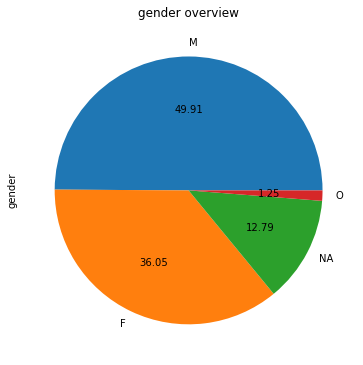

In [23]:
#General Overview of Starbucks customers
# Customer gender 
profile.gender.value_counts().plot(kind='pie', figsize=(6,10), autopct="%0.2f", title="gender overview")


In [24]:
#As for the income distribution we are going to look aat income histogram of starbucks customers
profile.income.mean()

65404.99156829799

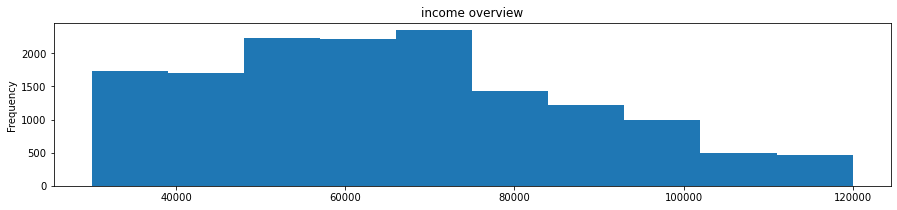

In [25]:
# here i excluded the profile with missing icomes and i did tht by excluding the age=NA since we know that
# a missing value in one column will be missing from the other
profile[profile.age != 'NA'].income.plot(kind='hist',title='income overview', figsize=(15,3));

<AxesSubplot:title={'center':'age groups overview'}>

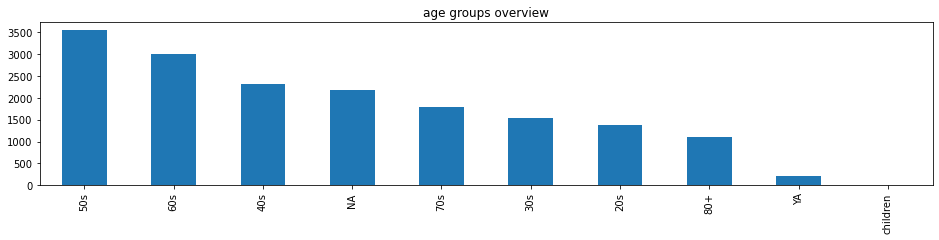

In [26]:
profile.age.value_counts().plot(kind='bar', figsize=(16,3), title='age groups overview')

<AxesSubplot:title={'center':'membership year overview'}>

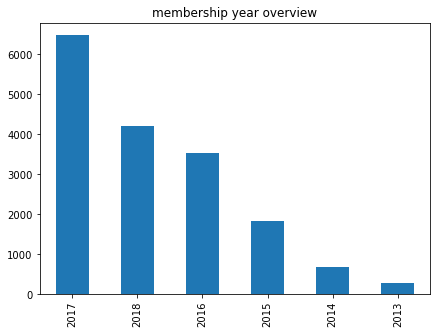

In [27]:
profile.year.value_counts().plot(kind='bar', title='membership year overview', figsize=(7,5))

In [28]:
temp = profile[profile.age != 'NA']

<AxesSubplot:title={'center':'customer age by gender'}, xlabel='age'>

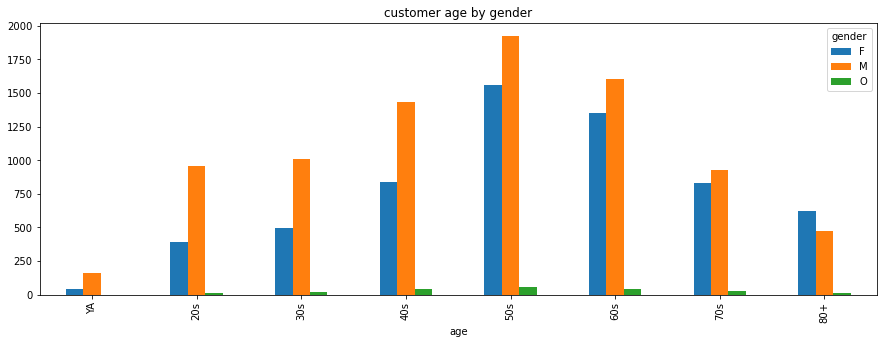

In [29]:
pd.crosstab(temp.age,temp.gender).plot(kind='bar',  figsize=(15,5), title='customer age by gender')

<AxesSubplot:title={'center':'customer age by gender'}, xlabel='age'>

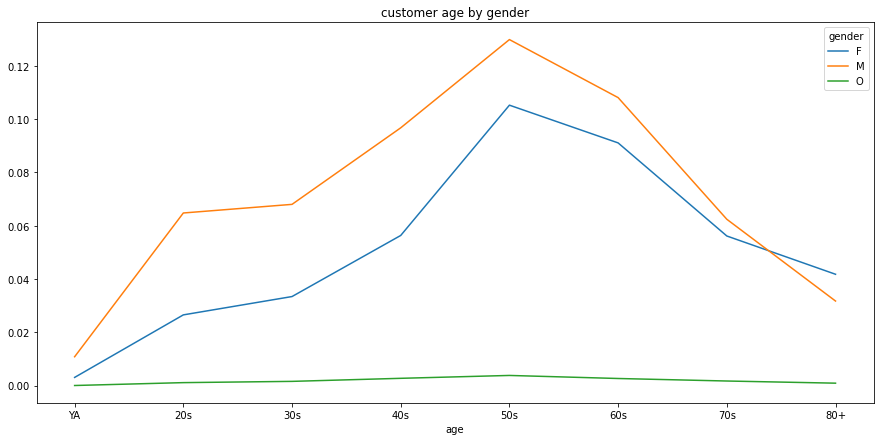

In [30]:
# a different view of the same data
pd.crosstab(temp.age,temp.gender, normalize="all").plot(kind="line",  figsize = (15,7), title='customer age by gender')

array([[<AxesSubplot:xlabel='income'>, <AxesSubplot:xlabel='income'>,
        <AxesSubplot:xlabel='income'>],
       [<AxesSubplot:xlabel='income'>, <AxesSubplot:xlabel='income'>,
        <AxesSubplot:xlabel='income'>],
       [<AxesSubplot:xlabel='income'>, <AxesSubplot:xlabel='income'>,
        <AxesSubplot:xlabel='income'>]], dtype=object)

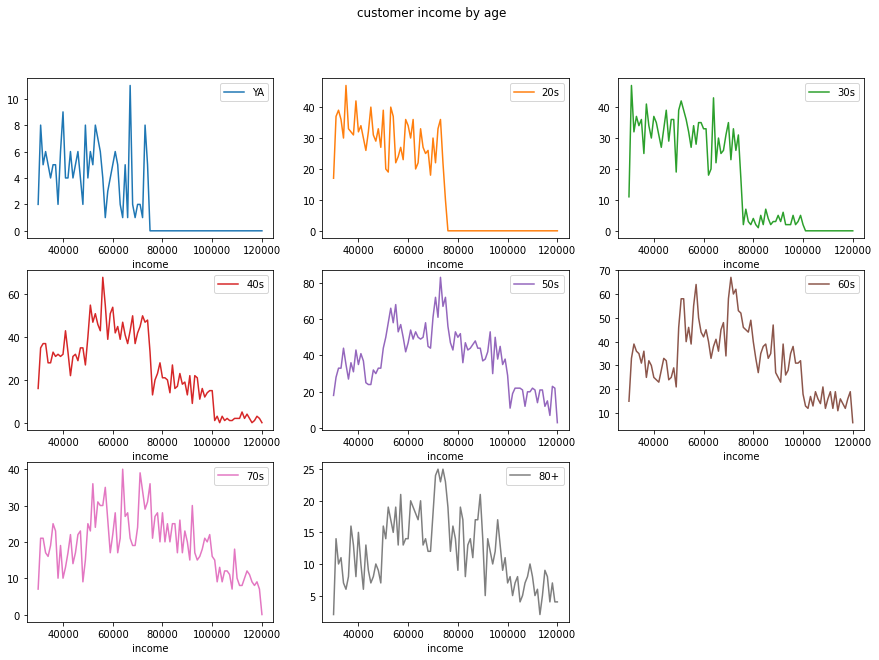

In [31]:
pd.crosstab(temp.income, temp.age).plot(subplots=True,  figsize = (15,10),layout=(3, 3), sharex=False, title='customer income by age') 

<AxesSubplot:title={'center':'customer income by gender'}, xlabel='income'>

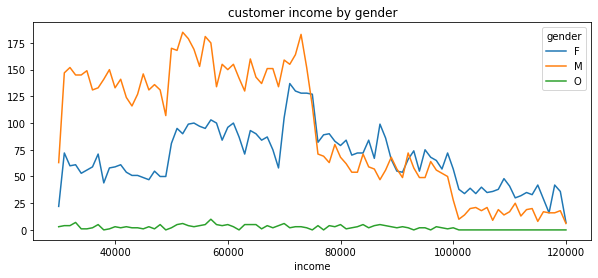

In [32]:
pd.crosstab(temp.income, temp.gender).plot( figsize = (10,4), title='customer income by gender')

### Detailed analysis of setbacks customer behaviour in relation to different factors
Here We will examine the data to see for a random set of 40 customers, the different events they were involved in during the experiment. This would provide some idea on how people behave for example:

* some people never complete an offer even though they have transactions.
*  in general, many customers who received offers viewed them.
*  -people with more transactions are more likely to complete offers.

<AxesSubplot:title={'center':'40 customer events overview'}, xlabel='person'>

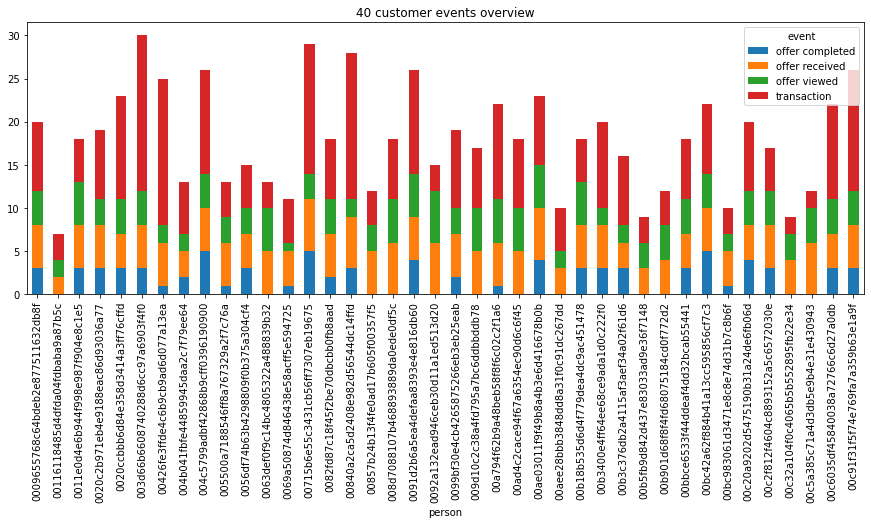

In [36]:
pd.crosstab(transcript.person,transcript.event).head(40).plot(kind='bar', stacked=True, figsize=(15,5), title='40 customer events overview')

<AxesSubplot:title={'center':'offer events overview'}, xlabel='offer_type'>

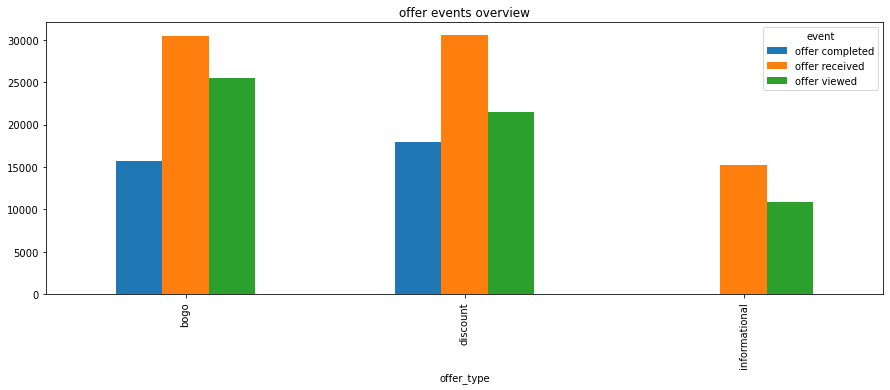

In [38]:
transcript_portfolio = pd.merge(transcript, portfolio, how='left', on='offer_id')
pd.crosstab(transcript_portfolio.offer_type,transcript_portfolio.event).plot(kind='bar', figsize=(15,5), title='offer events overview')

In [39]:
top_offers = transcript_portfolio[transcript_portfolio.event == 'offer completed'].offer_id.value_counts().head(3).reset_index()
top_offers.rename(columns={'index': 'offer_id', 'offer_id':'completed_count'}, inplace=True)
portfolio[portfolio['offer_id'].isin(top_offers.offer_id)]

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1


<AxesSubplot:title={'center':'top offer ids'}, ylabel='offer_id'>

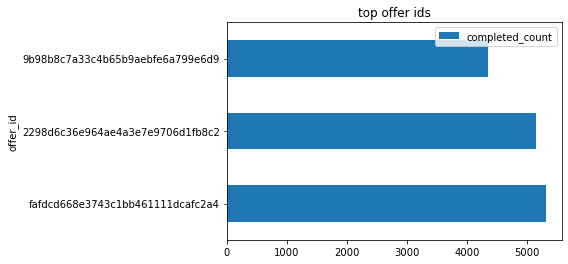

In [40]:
#plot top offers
top_offers.plot(y='completed_count', x='offer_id', kind='barh', title='top offer ids')

<AxesSubplot:title={'center':'top 30 spenders age groups'}>

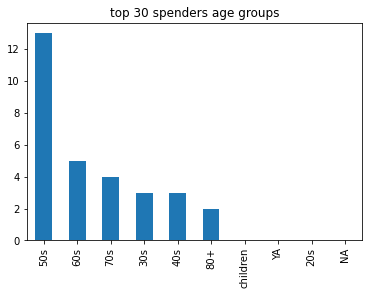

In [41]:
#customers who spent the most by age group
t = transcript[(transcript.amount != 0 )].groupby('person').amount.sum().reset_index().sort_values('amount', ascending=False)
top_paying_profiles = pd.merge(t,profile,how='left',on='person').head(30)
top_paying_profiles.age.value_counts().plot(kind='bar', title='top 30 spenders age groups')

<AxesSubplot:title={'center':'top 30 spenders gender'}, ylabel='gender'>

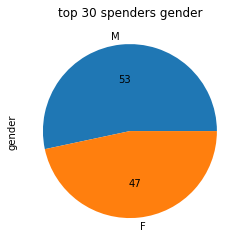

In [42]:
top_paying_profiles.gender.value_counts().plot(kind='pie', title='top 30 spenders gender', autopct="%0.0f")

<AxesSubplot:title={'center':'top 30 respondent customers age groups'}>

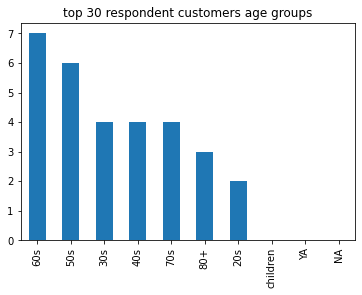

In [43]:
# most respondent customers
t = transcript[(transcript.event == 'offer completed')].groupby('person').event.count().reset_index().sort_values('event', ascending=False)
top_respondent_profiles = pd.merge(t,profile,how='left',on='person').head(30)
top_respondent_profiles.age.value_counts().plot(kind='bar', title='top 30 respondent customers age groups')

<AxesSubplot:title={'center':'top 30 respondent customers gender'}, ylabel='gender'>

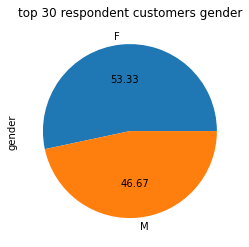

In [44]:
top_respondent_profiles.gender.value_counts().plot(kind='pie',autopct="%0.2f",  title='top 30 respondent customers gender')

In [45]:
transcript_profiles = pd.merge(transcript,profile,how='left',on='person')
all_merge = pd.merge(transcript_profiles,portfolio,on='offer_id')

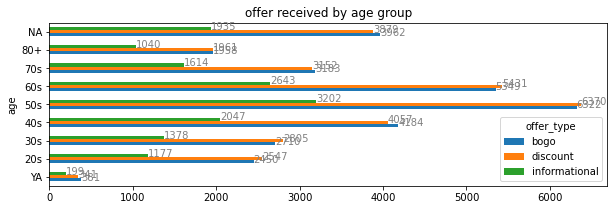

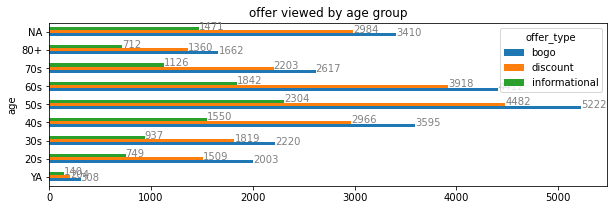

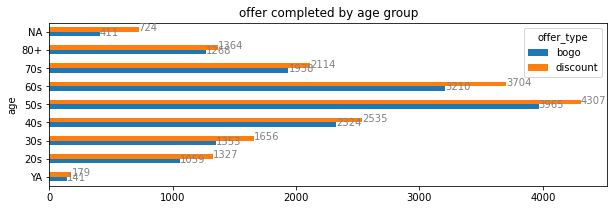

In [46]:
# age goups, offers and events
for i in transcript.event.unique():
    temp = all_merge[(all_merge.event == i )]
    t= pd.crosstab(temp["age"],temp["offer_type"])
    if t.shape[0] != 0:
        ax = t.plot(kind="barh",figsize=(10,3), title=i + ' by age group')
        for i in ax.patches:
            ax.text(i.get_width(), i.get_y()+.05, str(round((i.get_width()), 2)), color='grey')

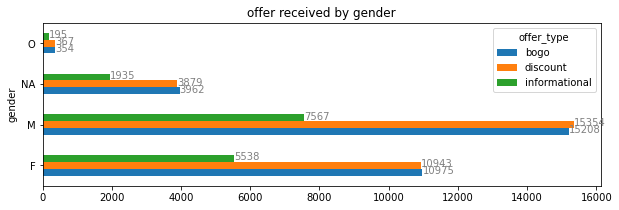

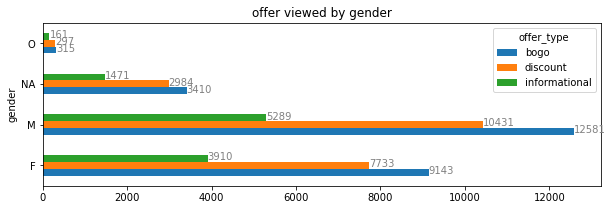

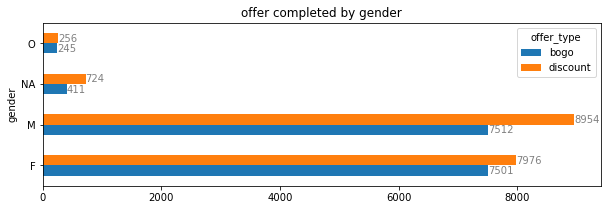

In [47]:
# gender, offers and events
for i in transcript.event.unique():
    temp = all_merge[(all_merge.event == i )]
    t= pd.crosstab(temp["gender"],temp["offer_type"])
    if t.shape[0] != 0:
        ax = t.plot(kind="barh",figsize=(10,3), title=i + ' by gender')
        
        for i in ax.patches:
            ax.text(i.get_width(), i.get_y()+.05, str(round((i.get_width()), 2)), color='grey')

### Part 3:  Build a model to predict which users are more likely to view then complete offers

Predict if a customer would view then complete an offer or now

#### Part 3.1: prepare the dataset
* seperate channels into columns and assign 0/1 values
* create new column for category columns with 0/1 values (offer types, gender, event, age)
* get only users who viewed offers then merge with users who completed offers
* drop unneeded columns
* fill nulls

In [48]:
df = all_merge.copy()

dummies = pd.get_dummies(df['offer_type'])
df = pd.concat([df, dummies], axis=1)


dummies = pd.get_dummies(df['gender'])
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['event'])
df = pd.concat([df, dummies], axis=1)


dummies = pd.get_dummies(df['age'])
df = pd.concat([df, dummies], axis=1)

df.head()

,person,event,time,amount,gained_reward,offer_id,gender,age,year,income,...,children,YA,20s,30s,40s,50s,60s,70s,80+,NA
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,70s,2017,100000.0,...,0,0,0,0,0,0,0,1,0,0
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,50s,2015,41000.0,...,0,0,0,0,0,1,0,0,0,0
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,40s,2016,33000.0,...,0,0,0,0,1,0,0,0,0,0
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,40s,2018,33000.0,...,0,0,0,0,1,0,0,0,0,0
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,50s,2017,80000.0,...,0,0,0,0,0,1,0,0,0,0


In [49]:
# get offer viewed rows 
df_view = df[df['offer viewed']==1]
df_view.drop(['offer completed'], axis = 1, inplace=True)

df_view.head()

C:\Users\Rahul\Miniconda3\envs\ml\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,person,event,time,amount,gained_reward,offer_id,gender,age,year,income,...,children,YA,20s,30s,40s,50s,60s,70s,80+,NA
1245,c099206f76b1414db7552f163520053c,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NA,NA,2015,65404.991568,...,0,0,0,0,0,0,0,0,0,1
1246,4293153650e04742b310ac06cd3810e9,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,50s,2018,51000.000000,...,0,0,0,0,0,1,0,0,0,0
1247,629fc02d56414d91bca360decdfa9288,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,50s,2018,72000.000000,...,0,0,0,0,0,1,0,0,0,0
1249,6e43570e4517416cb3bcadd49d3da70f,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,60s,2018,89000.000000,...,0,0,0,0,0,0,1,0,0,0
1250,be7ff3cb6bf84ce395471e52b64b70c6,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,60s,2018,66000.000000,...,0,0,0,0,0,0,1,0,0,0


In [50]:
df_complete = df[df['offer completed']==1][['offer_id','person', 'offer completed']]
df_complete.head()

,offer_id,person,offer completed
1248,9b98b8c7a33c4b65b9aebfe6a799e6d9,629fc02d56414d91bca360decdfa9288,1
1254,9b98b8c7a33c4b65b9aebfe6a799e6d9,b860d355ef6e4c66b5d5a837c56ef32d,1
1255,9b98b8c7a33c4b65b9aebfe6a799e6d9,99297ea01107436fa8c2e2bc86f55d89,1
1263,9b98b8c7a33c4b65b9aebfe6a799e6d9,16dc4306258b4fef90ffe99f53ed7952,1
1267,9b98b8c7a33c4b65b9aebfe6a799e6d9,0454292436bd4cee98e8ec873e30433e,1


In [51]:
final_df = df_view.merge(df_complete,right_on=['offer_id','person'],left_on=['offer_id','person'],how='left')

final_df.head()

,person,event,time,amount,gained_reward,offer_id,gender,age,year,income,...,YA,20s,30s,40s,50s,60s,70s,80+,NA,offer completed
0,c099206f76b1414db7552f163520053c,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NA,NA,2015,65404.991568,...,0,0,0,0,0,0,0,0,1,NaN
1,4293153650e04742b310ac06cd3810e9,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,50s,2018,51000.000000,...,0,0,0,0,1,0,0,0,0,1.0
2,629fc02d56414d91bca360decdfa9288,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,50s,2018,72000.000000,...,0,0,0,0,1,0,0,0,0,1.0
3,6e43570e4517416cb3bcadd49d3da70f,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,60s,2018,89000.000000,...,0,0,0,0,0,1,0,0,0,NaN
4,be7ff3cb6bf84ce395471e52b64b70c6,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,60s,2018,66000.000000,...,0,0,0,0,0,1,0,0,0,NaN


In [52]:
#drop un-needed columns
final_df.drop(['offer_type','gender','year','event','gained_reward','person','offer_id',
               'time','offer received', 'offer viewed','age'], axis = 1, inplace=True)

In [53]:
final_df.fillna(0, inplace=True)

In [54]:
final_df.head()

,amount,income,reward,difficulty,duration,email,mobile,social,web,bogo,...,YA,20s,30s,40s,50s,60s,70s,80+,NA,offer completed
0,0.0,65404.991568,5,5,7,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0.0
1,0.0,51000.000000,5,5,7,1,1,0,1,1,...,0,0,0,0,1,0,0,0,0,1.0
2,0.0,72000.000000,5,5,7,1,1,0,1,1,...,0,0,0,0,1,0,0,0,0,1.0
3,0.0,89000.000000,5,5,7,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0.0
4,0.0,66000.000000,5,5,7,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0.0


In [55]:
final_df.columns

Index(['amount', 'income', 'reward', 'difficulty', 'duration', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational', 'F',
       'M', 'NA', 'O', 'children', 'YA', '20s', '30s', '40s', '50s', '60s',
       '70s', '80+', 'NA', 'offer completed'],
      dtype='object')

In [56]:
def create_model(classifer, df):    
    """
    a function that will create a model: train -> predict -> score -> print result
              
    args:
    classifer: object of classifer
    df: dataframe ready for training that must have "offer completed" column
    
    """
    
    print('Training with ' + str(classifer).removesuffix('()') + "...")
    
    features = df.drop(['offer completed'], axis = 1)
    target = df['offer completed']
    
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

    # fit classifier
    clf = classifer.fit(X_train, y_train)

    # predict on training and test data
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # accuracy on training and test data
    score_train = accuracy_score( y_train , predict_train )
    score_test = accuracy_score( y_test , predict_test )

    # display classifier clf_result dict 
    print('Training Accuracy:' , score_train)
    print('Testing Accuracy :', score_test)

In [57]:
create_model(AdaBoostClassifier(), final_df)
create_model(GaussianNB(), final_df)
create_model(DecisionTreeClassifier(), final_df)
create_model(RandomForestClassifier(), final_df)

Training with AdaBoostClassifier...
Training Accuracy: 0.8095842142353771
Testing Accuracy : 0.8079246194733027
Training with GaussianNB...
Training Accuracy: 0.775113258834189
Testing Accuracy : 0.7739188209712491
Training with DecisionTreeClassifier...
Training Accuracy: 0.8507198228128461
Testing Accuracy : 0.7835829910606427
Training with RandomForestClassifier...
Training Accuracy: 0.8507198228128461
Testing Accuracy : 0.7933679632761537


#### Model improvment with GridSearchCV
First we define the paramiters, then we use gridSearch to find the best ones.
notes about the default parameters for AdaBoostClassifier:
* n_estimators default=50
* learning_rate=1.
* algorithm=’SAMME.R’

In [58]:
params = {
    'n_estimators': [40, 45, 50, 55, 60],
    'learning_rate' : [0.8,0.9,1,1.1,1.2],
    'algorithm':['SAMME', 'SAMME.R']
 }

#     'n_estimators': [50, 100,150,200],
#     'learning_rate' : [0.01,0.05,0.1,0.3,1],
#     'algorithm':['SAMME', 'SAMME.R']

df = final_df.copy()
features = df.drop(['offer completed'], axis = 1)
target = df['offer completed']
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)
    
cv = GridSearchCV(AdaBoostClassifier(), param_grid=params, n_jobs = -1, scoring='accuracy')

cv.fit(X_train,y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.8, 0.9, 1, 1.1, 1.2],
                         'n_estimators': [40, 45, 50, 55, 60]},
             scoring='accuracy')

In [59]:
# The best parameters
cv.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.9, 'n_estimators': 45}

In [60]:
create_model(AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.9, n_estimators=45), final_df)

Training with AdaBoostClassifier(learning_rate=0.9, n_estimators=45)...
Training Accuracy: 0.8101479915433404
Testing Accuracy : 0.8090722396714182
